In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier
from sklearn import tree
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Dense

In [3]:
class CFG:
    outlier_clipper = True
    outlier_remover = False
    outlier_replacer = False
    
    one_hot_encoder = False
    label_encoder = True
    ordinal_encoder = True
    
    min_max_scaler = True
    robust_scaler = False
    standard_scaler = False

In [4]:
pd.set_option("display.max_columns",500)
train_data = pd.read_csv("/kaggle/input/datathon2023/train.csv")
df = train_data.copy()
df.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


In [5]:
df.drop("index", axis=1, inplace=True)

def check_data(dataframe, head=5):
    print("\n******Shape******")
    print(f'Shape     : {df.shape}\n')
    print("\n******Info******")
    print(dataframe.info())
    print("\n******Duplicated Values******")
    print(dataframe.duplicated().sum())
    print("\n******Unique Values******")
    print(dataframe.nunique())
    
check_data(df)


******Shape******
Shape     : (5460, 13)


******Info******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş Grubu                                   5460 non-null   object 
 2   Medeni Durum                                5460 non-null   object 
 3   Eğitim Düzeyi                               5460 non-null   object 
 4   İstihdam Durumu                             5460 non-null   object 
 5   Yıllık Ortalama Gelir                       5460 non-null   float64
 6   Yaşadığı Şehir                              5460 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 9   Yıllık Ortalama Sipariş 

In [6]:
df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
Yıllık Ortalama Gelir,5460.0,363571.133428,219714.442407,43922.988693,150628.727704,215693.439307,286925.436073,468188.221798,890884.524597,1.192437e+06
Yıllık Ortalama Satın Alım Miktarı,5460.0,16616.612217,14099.171704,2859.254000,3750.944992,4931.859057,8426.818967,30579.244695,41256.719718,4.860559e+04
Yıllık Ortalama Sipariş Verilen Ürün Adedi,5460.0,24.040884,14.945655,0.000000,4.012480,11.550502,20.095924,35.918161,51.775273,6.461620e+01
Yıllık Ortalama Sepete Atılan Ürün Adedi,5460.0,73.445693,47.214184,3.977559,9.478686,25.009168,82.485579,104.473291,159.470950,2.423084e+02


In [7]:
object_cols  = df.select_dtypes(include=['object', 'category'])
for column in object_cols:
    print(f"Column: {column}")
    
    has_space = df[column].apply(lambda x: bool(re.findall(r'" "', str(x))))
    print("Space value:", has_space.sum())
    
    has_special_char = df[column].apply(lambda x: bool(re.findall(r'[!@#]', str(x))))
    print("Special char value:", has_special_char.sum(),"\n")
    

Column: Cinsiyet
Space value: 0
Special char value: 0 

Column: Yaş Grubu
Space value: 0
Special char value: 0 

Column: Medeni Durum
Space value: 0
Special char value: 0 

Column: Eğitim Düzeyi
Space value: 0
Special char value: 0 

Column: İstihdam Durumu
Space value: 0
Special char value: 0 

Column: Yaşadığı Şehir
Space value: 0
Special char value: 0 

Column: En Çok İlgilendiği Ürün Grubu
Space value: 0
Special char value: 0 

Column: Eğitime Devam Etme Durumu
Space value: 0
Special char value: 0 

Column: Öbek İsmi
Space value: 0
Special char value: 0 



In [8]:
num_cols = df.select_dtypes(include=[int, float])

for column in num_cols:
    zero_count = (df[column] == 0).sum()
    print(f"'{column}' zero count: {zero_count}")

'Yıllık Ortalama Gelir' zero count: 0
'Yıllık Ortalama Satın Alım Miktarı' zero count: 0
'Yıllık Ortalama Sipariş Verilen Ürün Adedi' zero count: 39
'Yıllık Ortalama Sepete Atılan Ürün Adedi' zero count: 0


In [9]:
df[df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]==0]

,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
169,Erkek,41-50,Evli,Ortaokul Mezunu,Düzenli ve Ücretli Bir İşi Var,251278.182344,Köy veya Kasaba,Giyim,5023.314883,0.0,Etmiyor,obek_1,10.069459
208,Erkek,18-30,Bekar,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,231244.677536,Büyük Şehir,Giyim,5480.873620,0.0,Etmiyor,obek_1,8.437864
212,Kadın,41-50,Evli,Yüksekokul Mezunu,Düzenli ve Ücretli Bir İşi Var,155449.231393,Küçük Şehir,Giyim,4634.189363,0.0,Etmiyor,obek_1,11.329029
380,Erkek,51-60,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,185936.844199,Küçük Şehir,Ev ve Mobilya,4579.454580,0.0,Etmiyor,obek_1,8.576521
397,Kadın,51-60,Bekar,İlkokul Mezunu,Düzenli ve Ücretli Bir İşi Var,291987.124944,Köy veya Kasaba,Kozmetik,5408.923105,0.0,Etmiyor,obek_1,11.479481
895,Kadın,18-30,Evli,İlkokul Mezunu,Düzenli ve Ücretli Bir İşi Var,170219.240001,Kırsal,Giyim,5394.862651,0.0,Etmiyor,obek_1,9.377013
926,Erkek,31-40,Evli,Lise Mezunu,Kendi İşinin Sahibi,304296.021695,Büyük Şehir,Giyim,4709.465891,0.0,Etmiyor,obek_1,11.889258
961,Erkek,>60,Evli,Eğitimsiz,Düzenli ve Ücretli Bir İşi Var,233889.193730,Küçük Şehir,Giyim,5202.985514,0.0,Etmiyor,obek_1,10.239161
1074,Erkek,31-40,Bekar,İlkokul Mezunu,Düzenli ve Ücretli Bir İşi Var,324307.460992,Köy veya Kasaba,Giyim,5183.673428,0.0,Etmiyor,obek_1,11.959095
1240,Kadın,31-40,Evli,Doktora Ötesi,Kendi İşinin Sahibi,159105.773277,Köy veya Kasaba,Giyim,5678.373255,0.0,Etmiyor,obek_1,12.970593


In [10]:
df['Yıllık Ortalama Sipariş Verilen Ürün Adedi'] = df['Yıllık Ortalama Sipariş Verilen Ürün Adedi'].replace(0, np.nan)

In [11]:
df.dropna(inplace=True)

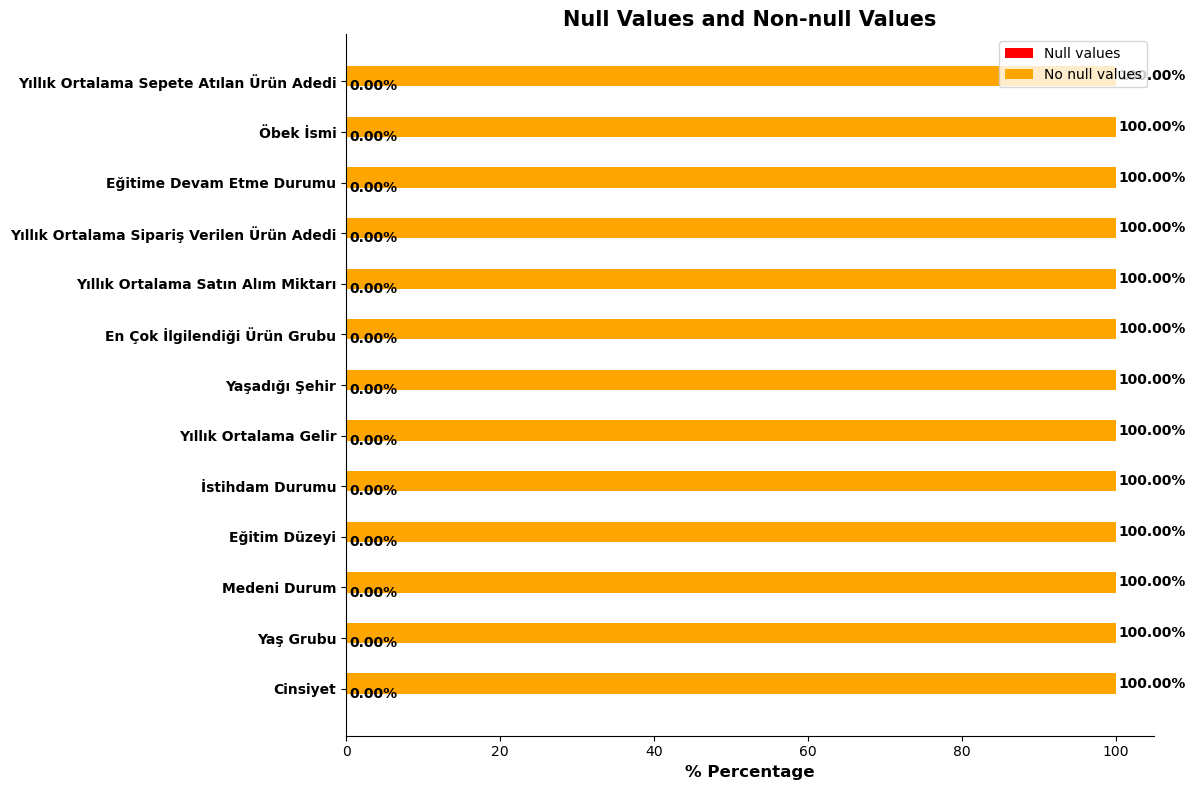

In [12]:
df_null_values = df.isnull().sum().to_frame().rename(columns={0: 'Count'})
df_null_values['Percentage_nulls'] = (df_null_values['Count'] / len(df)) * 100
df_null_values['Percentage_no_nulls'] = 100 - df_null_values['Percentage_nulls']

n = len(df_null_values.index)
x = np.arange(n)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
gap = 0.2

rects1 = ax.barh(x - gap / 2, df_null_values['Percentage_nulls'], bar_width, label='Null values', color='red')
rects2 = ax.barh(x + gap / 2, df_null_values['Percentage_no_nulls'], bar_width, label='No null values', color='orange')

ax.set_title('Null Values and Non-null Values', fontsize=15, fontweight='bold')
ax.set_xlabel('% Percentage', fontsize=12, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(df_null_values.index, fontsize=10, fontweight='bold') 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}%',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(2, 0),
                    textcoords="offset points",
                    ha='left', va='center', size=10, weight='bold')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

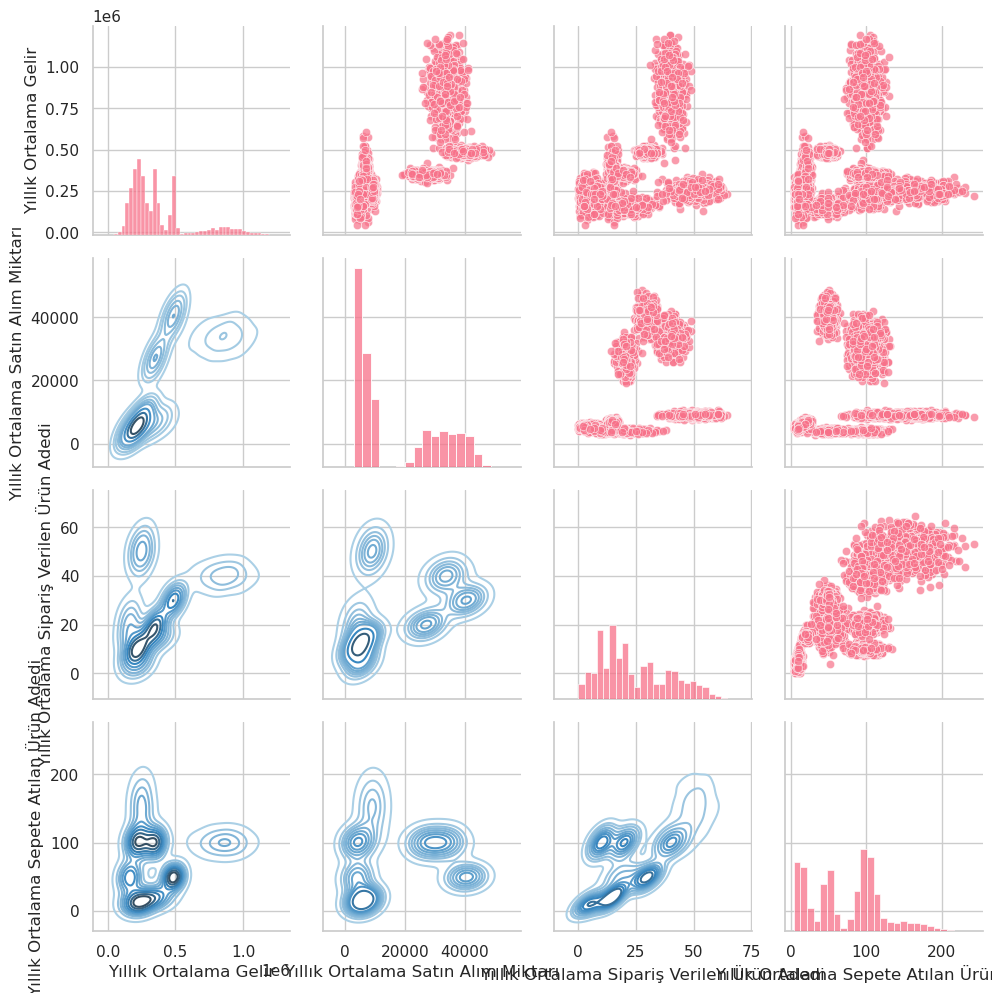

In [13]:
def scatter_matrix(dataframe):
    sns.set(style="whitegrid")
    sns.set_palette("husl") 
    g = sns.PairGrid(dataframe)
    g.map_upper(sns.scatterplot, alpha=0.7)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_diag(sns.histplot, kde_kws={"color": "k"})
    plt.show()

scatter_matrix(df)

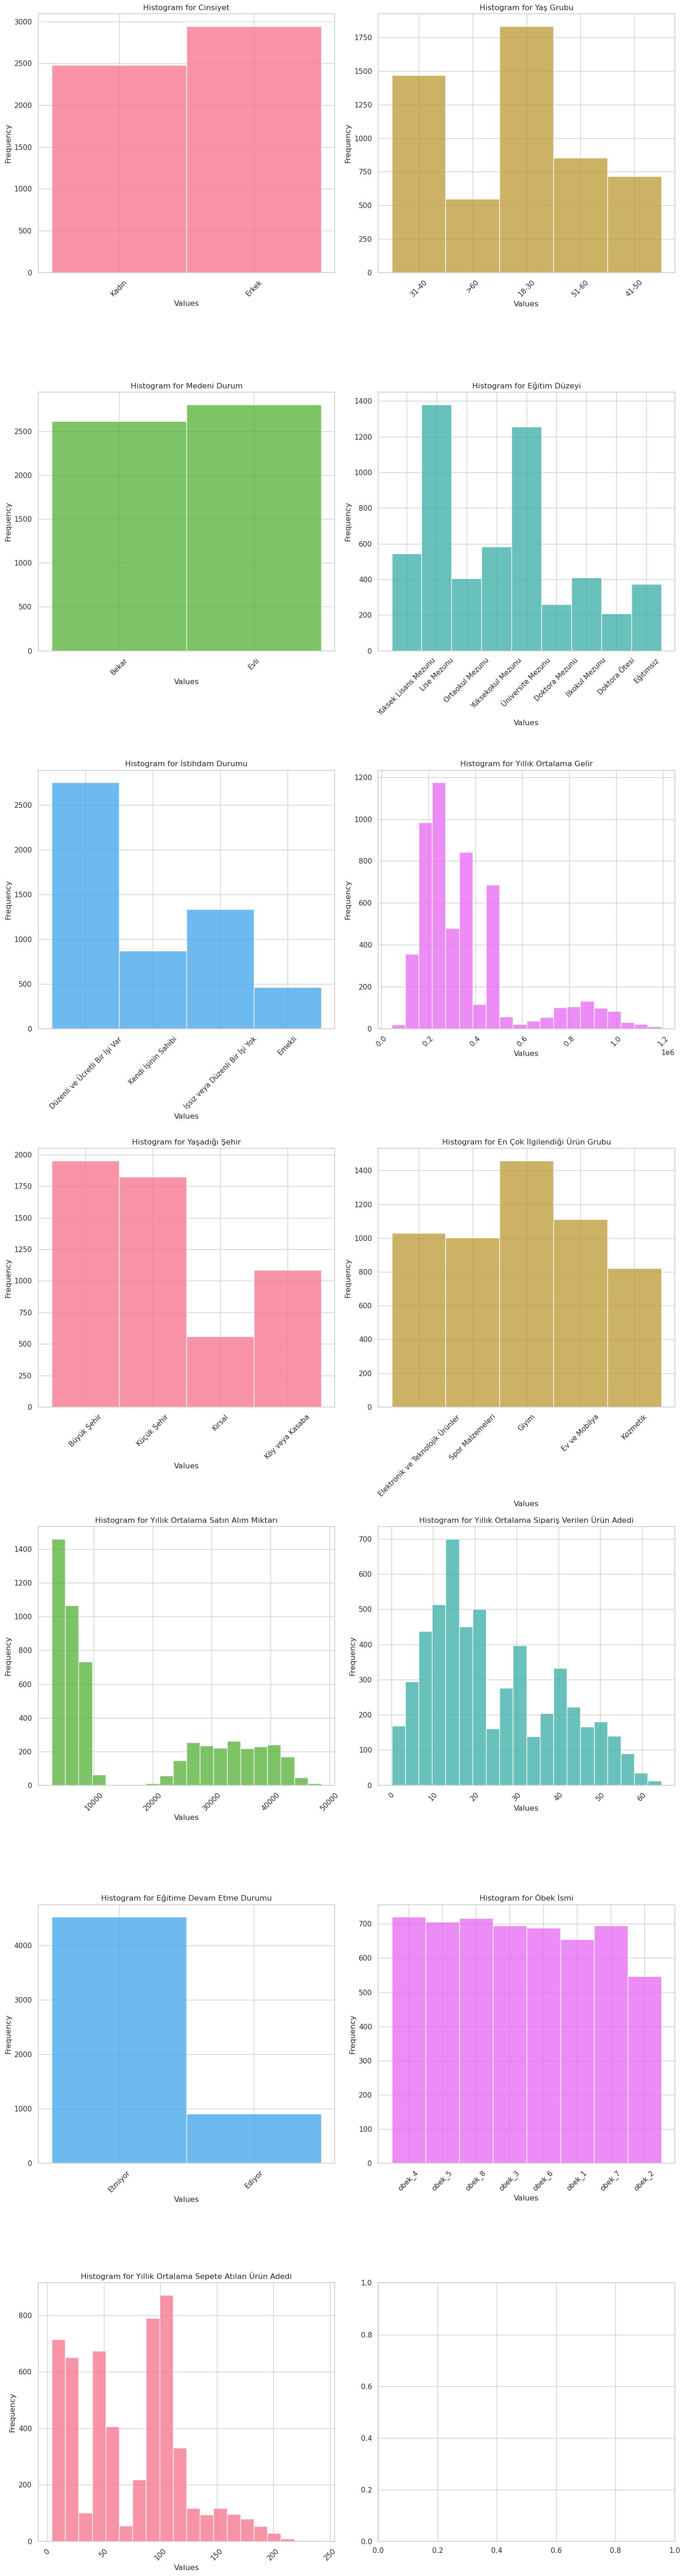

In [14]:
def histogram_subplots(dataframe, cols_per_row=2):
    num_cols = dataframe.shape[1]
    num_rows = (num_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 8 * num_rows))
    axes = axes.ravel()
    
    for i, col in enumerate(dataframe.columns):
        ax = axes[i]
        sns.histplot(dataframe[col], ax=ax, bins=20, color=sns.color_palette()[i % len(sns.color_palette())])
        ax.set_title(f"Histogram for {col}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    plt.show()

histogram_subplots(df, cols_per_row=2)

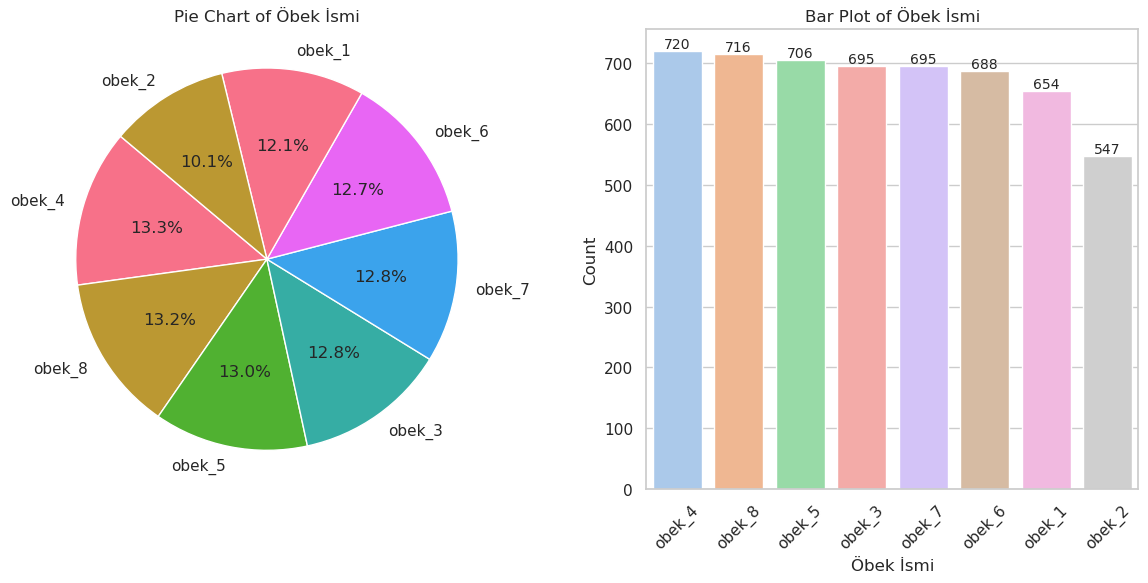

In [15]:
def plot_target(dataframe, column):
    counts = dataframe[column].value_counts()
    labels = counts.index
    values = counts.values
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axes[0].axis('equal')
    axes[0].set_title(f"Pie Chart of {column}")

    sns.barplot(x=labels, y=values, palette='pastel', ax=axes[1])
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Count')
    axes[1].set_title(f"Bar Plot of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    
    for index, value in enumerate(values):
        axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()
    
plot_target(df,'Öbek İsmi')

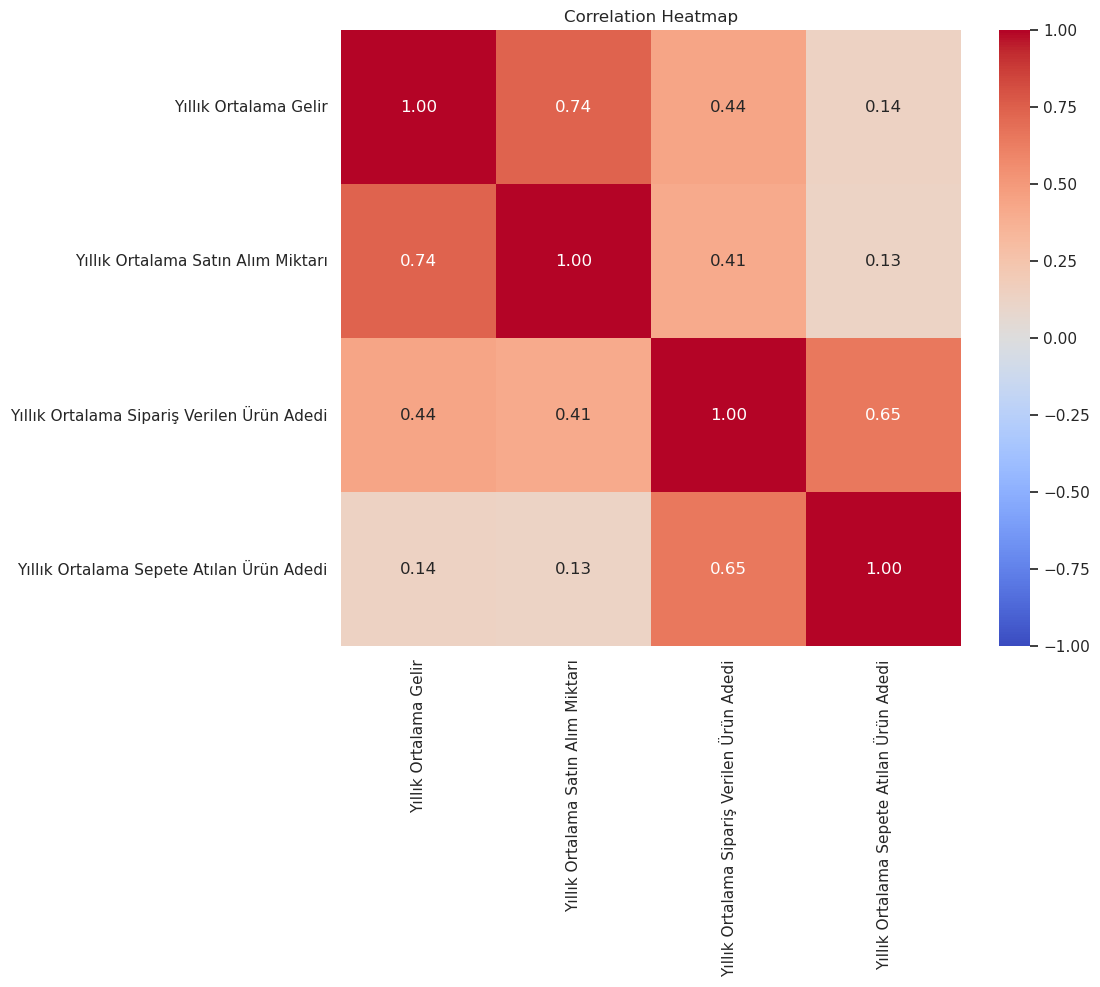

In [16]:
def plot_correlation_heatmap(dataframe):
    correlation_matrix = dataframe.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()

plot_correlation_heatmap(df)

In [17]:
def grab_col_names(dataframe, cat_th=10, car_th=20, print_results=True):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    cat_cols = cat_cols + num_but_cat
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    if print_results:
        print(f'Observations {dataframe.shape[0]}')
        print(f'Variables:  {dataframe.shape[1]}')
        print(f'cat_cols:  {len(cat_cols)}')
        print(f'num_cols:  {len(num_cols)}')
        print(f'cat_but_car:  {len(cat_but_car)}')
        print(f'num_but_cat:  {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations 5421
Variables:  13
cat_cols:  9
num_cols:  4
cat_but_car:  0
num_but_cat:  0


In [18]:
def outlier_thresholds(dataframe, col, low_quantile=0.25, up_quantile=0.75):
    
    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)
    
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    
    return  low_limit, up_limit

In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(f"{col}, outlier detection is {check_outlier(df, col)}")

Yıllık Ortalama Gelir, outlier detection is True
Yıllık Ortalama Satın Alım Miktarı, outlier detection is False
Yıllık Ortalama Sipariş Verilen Ürün Adedi, outlier detection is False
Yıllık Ortalama Sepete Atılan Ürün Adedi, outlier detection is True


In [20]:
class DataProcessorOutlier:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.outlier_clipper:
            print("Applying outlier clipping...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    low_limit, up_limit = outlier_thresholds(dataframe, col)
                    dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
                    dataframe.loc[(dataframe[col] > up_limit), col] = up_limit
            print("Outlier clipping applied.")

        if self.cfg.outlier_remover:
            print("Applying outlier removal...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.25)
                    q3_val = dataframe[col].quantile(0.75)
                    dataframe = dataframe.loc[(dataframe[col] >= q1_val) & (dataframe[col] <= q3_val)]
            print("Outlier removal applied.")
            
        if self.cfg.outlier_replacer:
            print("Applying outlier replacement...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.25)
                    q3_val = dataframe[col].quantile(0.75)
                    median_val = dataframe[col].median()
                    dataframe[col] = dataframe[col].where((dataframe[col] >= q1_val) & (dataframe[col] <= q3_val), median_val)
            print("Outlier replacement applied.")

        return dataframe.head()

data_processor = DataProcessorOutlier(CFG())
data_processor.process_data(df)

Applying outlier clipping...
Outlier clipping applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


In [21]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()>2 and col not in ['index', 'Öbek İsmi']]
            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols, drop_first=True)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")

        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()==2]
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    if col != 'Öbek İsmi':
                        unique_values = sorted(dataframe[col].unique())
                        ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                        dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
df = data_processor_encode.encode_data(df)
df.head()

Label encoding applied.
Ordinal encoding applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,1,1,0,5,0,748266.440879,0,0,32010.900881,37.310644,1,obek_4,102.936904
1,0,4,1,3,2,246298.609605,2,4,4145.729891,11.554851,1,obek_5,82.176053
2,0,0,0,3,0,268582.732360,2,2,9924.379414,55.353236,0,obek_8,141.661426
3,0,3,1,3,2,327721.837865,3,2,6417.780714,15.417239,1,obek_3,17.097397
4,0,1,1,4,3,397431.626948,0,2,7886.663061,14.689837,1,obek_3,20.470459


In [22]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        num_cols = ['Yıllık Ortalama Gelir', 'Yıllık Ortalama Satın Alım Miktarı', 
                    'Yıllık Ortalama Sipariş Verilen Ürün Adedi', 
                    'Yıllık Ortalama Sepete Atılan Ürün Adedi']

        if self.cfg.min_max_scaler:
            print("Applying Min-Max scaling...")
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            print("Applying Standard scaling...")
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            print("Applying Robust scaling...")
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe

data_processor_scale = DataProcessorScaled(CFG())
df = data_processor_scale.scaled_data(df)
df.head()

Applying Min-Max scaling...
Min-Max scaling applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,1,1,0,5,0,0.876118,0,0,0.637245,0.576862,1,obek_4,0.454099
1,0,4,1,3,2,0.251731,2,4,0.028122,0.177741,1,obek_5,0.358833
2,0,0,0,3,0,0.279450,2,2,0.154441,0.856458,0,obek_8,0.631797
3,0,3,1,3,2,0.353012,3,2,0.077788,0.237594,1,obek_3,0.060204
4,0,1,1,4,3,0.439722,0,2,0.109898,0.226322,1,obek_3,0.075682


In [23]:
mapping = {
    "obek_1": 1,
    "obek_2": 2,
    "obek_3": 3,
    "obek_4": 4,
    "obek_5": 5,
    "obek_6": 6,
    "obek_7": 7,
    "obek_8": 8
}

df["Öbek İsmi"] = df["Öbek İsmi"].map(mapping)

In [24]:
test_size = 0.2
random_state = 42
X = df.drop(columns=['Öbek İsmi'])
y = df['Öbek İsmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [25]:
def model():
    
    models = {
        'LogisticRegression': LogisticRegression(max_iter=10000),
        'DecisionTree': tree.DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'CatBoost': CatBoostClassifier(verbose=False),
        'LightGBM': lgb.LGBMClassifier(verbose=-1),
        'GradientBoosting': GradientBoostingClassifier()
    }

    results = {}

    for i, (model_name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
    
    return results

def model_to_dataframe(df):
    results = model()
    result_df = pd.DataFrame(results).T
    result_df = result_df.sort_values(by='Accuracy', ascending=False)
    return result_df

model_to_dataframe(df)

,Accuracy,Precision,Recall,F1 Score
RandomForest,0.964977,0.965129,0.964977,0.965013
CatBoost,0.964977,0.965129,0.964977,0.965013
LightGBM,0.963134,0.963343,0.963134,0.963178
LogisticRegression,0.952995,0.953281,0.952995,0.953064
GradientBoosting,0.949309,0.949760,0.949309,0.949383
DecisionTree,0.903226,0.904469,0.903226,0.903352


In [26]:
test_x = pd.read_csv("/kaggle/input/datathon2023/test_x.csv")
test_data = test_x.copy()

In [27]:
test_data.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Erkek,51-60,Evli,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,365331.930346,Köy veya Kasaba,Giyim,5566.587664,15.442635,Etmiyor,19.646460
1,1,Erkek,41-50,Bekar,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,414899.236174,Büyük Şehir,Spor Malzemeleri,6756.766203,14.957246,Etmiyor,19.675863
2,2,Kadın,>60,Evli,Eğitimsiz,İşsiz veya Düzenli Bir İşi Yok,152825.872271,Küçük Şehir,Giyim,4493.915682,10.907930,Etmiyor,46.904518
3,3,Kadın,51-60,Evli,Doktora Ötesi,Düzenli ve Ücretli Bir İşi Var,489052.908472,Köy veya Kasaba,Kozmetik,42670.646595,32.333021,Etmiyor,48.083609
4,4,Erkek,18-30,Evli,Yüksek Lisans Mezunu,Kendi İşinin Sahibi,323635.711534,Küçük Şehir,Giyim,5959.266948,4.519968,Etmiyor,12.752491


In [28]:
test_data.drop("index", axis=1, inplace=True)

def check_data(dataframe):
    print("\n******Shape******")
    print(f'Shape     : {dataframe.shape}\n')
    print("\n******Info******")
    print(dataframe.info())
    print("\n******Duplicated Values******")
    print(dataframe.duplicated().sum())
    print("\n******Unique Values******")
    print(dataframe.nunique())
    
check_data(test_data)


******Shape******
Shape     : (2340, 12)


******Info******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    2340 non-null   object 
 1   Yaş Grubu                                   2340 non-null   object 
 2   Medeni Durum                                2340 non-null   object 
 3   Eğitim Düzeyi                               2340 non-null   object 
 4   İstihdam Durumu                             2340 non-null   object 
 5   Yıllık Ortalama Gelir                       2340 non-null   float64
 6   Yaşadığı Şehir                              2340 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               2340 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          2340 non-null   float64
 9   Yıllık Ortalama Sipariş 

In [29]:
test_data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
Yıllık Ortalama Gelir,2340.0,362252.366863,223206.339620,80656.752683,151306.920069,212008.058731,283694.655987,466988.700685,901130.270949,1.229399e+06
Yıllık Ortalama Satın Alım Miktarı,2340.0,16674.303935,14266.101056,2870.657175,3683.257239,4807.074240,8186.095300,30747.419142,41350.997031,4.638054e+04
Yıllık Ortalama Sipariş Verilen Ürün Adedi,2340.0,23.465787,14.559035,0.000000,3.910384,11.336283,20.094319,33.431156,50.803130,6.401748e+01
Yıllık Ortalama Sepete Atılan Ürün Adedi,2340.0,72.078920,46.311708,5.283642,9.390224,24.383782,71.033886,104.202802,154.031129,2.377686e+02


In [30]:
object_cols  = test_data.select_dtypes(include=['object', 'category'])
for column in object_cols:
    print(f"Column: {column}")
    
    has_space = df[column].apply(lambda x: bool(re.findall(r'" "', str(x))))
    print("Space value:", has_space.sum())
    
    has_special_char = df[column].apply(lambda x: bool(re.findall(r'[!@#]', str(x))))
    print("Special char value:", has_special_char.sum(),"\n")

Column: Cinsiyet
Space value: 0
Special char value: 0 

Column: Yaş Grubu
Space value: 0
Special char value: 0 

Column: Medeni Durum
Space value: 0
Special char value: 0 

Column: Eğitim Düzeyi
Space value: 0
Special char value: 0 

Column: İstihdam Durumu
Space value: 0
Special char value: 0 

Column: Yaşadığı Şehir
Space value: 0
Special char value: 0 

Column: En Çok İlgilendiği Ürün Grubu
Space value: 0
Special char value: 0 

Column: Eğitime Devam Etme Durumu
Space value: 0
Special char value: 0 



In [31]:
num_cols = test_data.select_dtypes(include=[int, float])

for column in num_cols:
    zero_count = (test_data[column] == 0).sum()
    print(f"'{column}' zero count: {zero_count}")

'Yıllık Ortalama Gelir' zero count: 0
'Yıllık Ortalama Satın Alım Miktarı' zero count: 0
'Yıllık Ortalama Sipariş Verilen Ürün Adedi' zero count: 21
'Yıllık Ortalama Sepete Atılan Ürün Adedi' zero count: 0


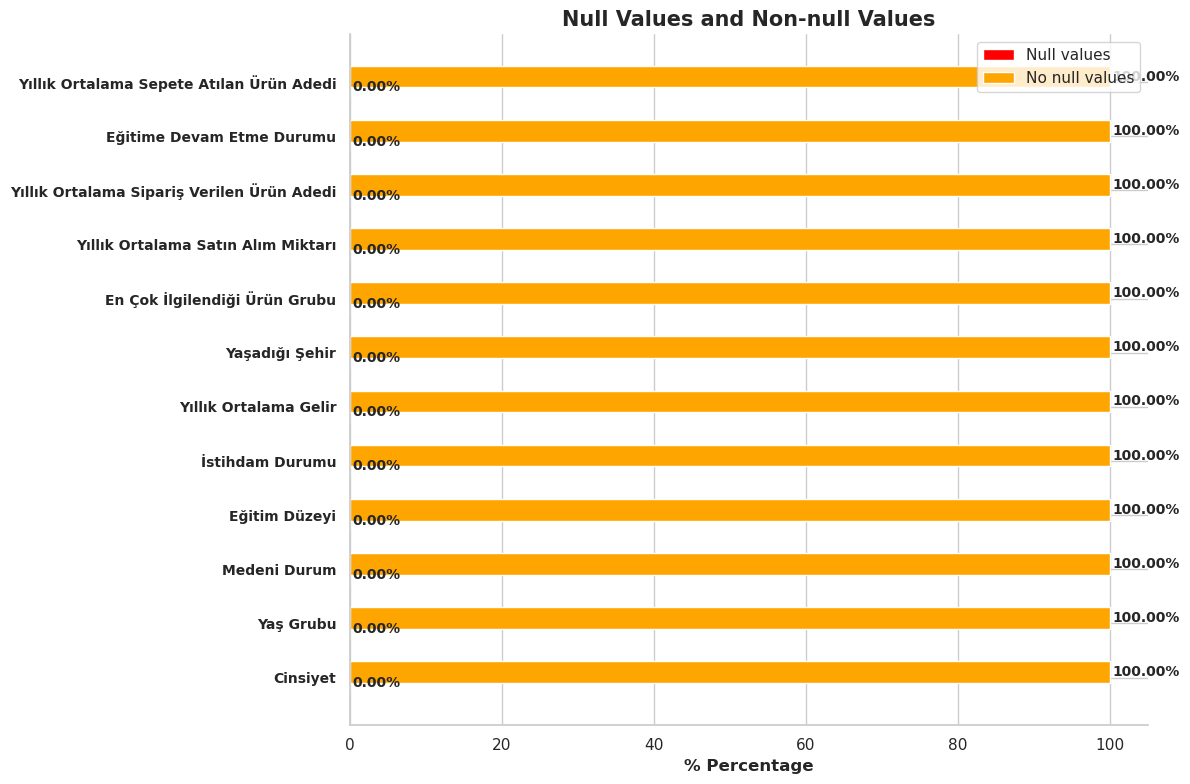

In [32]:
test_null_values = test_data.isnull().sum().to_frame().rename(columns={0: 'Count'})
test_null_values['Percentage_nulls'] = (test_null_values['Count'] / len(test_data)) * 100
test_null_values['Percentage_no_nulls'] = 100 - test_null_values['Percentage_nulls']

n = len(test_null_values.index)
x = np.arange(n)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
gap = 0.2

rects1 = ax.barh(x - gap / 2, test_null_values['Percentage_nulls'], bar_width, label='Null values', color='red')
rects2 = ax.barh(x + gap / 2, test_null_values['Percentage_no_nulls'], bar_width, label='No null values', color='orange')

ax.set_title('Null Values and Non-null Values', fontsize=15, fontweight='bold')
ax.set_xlabel('% Percentage', fontsize=12, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(test_null_values.index, fontsize=10, fontweight='bold') 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}%',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(2, 0),
                    textcoords="offset points",
                    ha='left', va='center', size=10, weight='bold')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

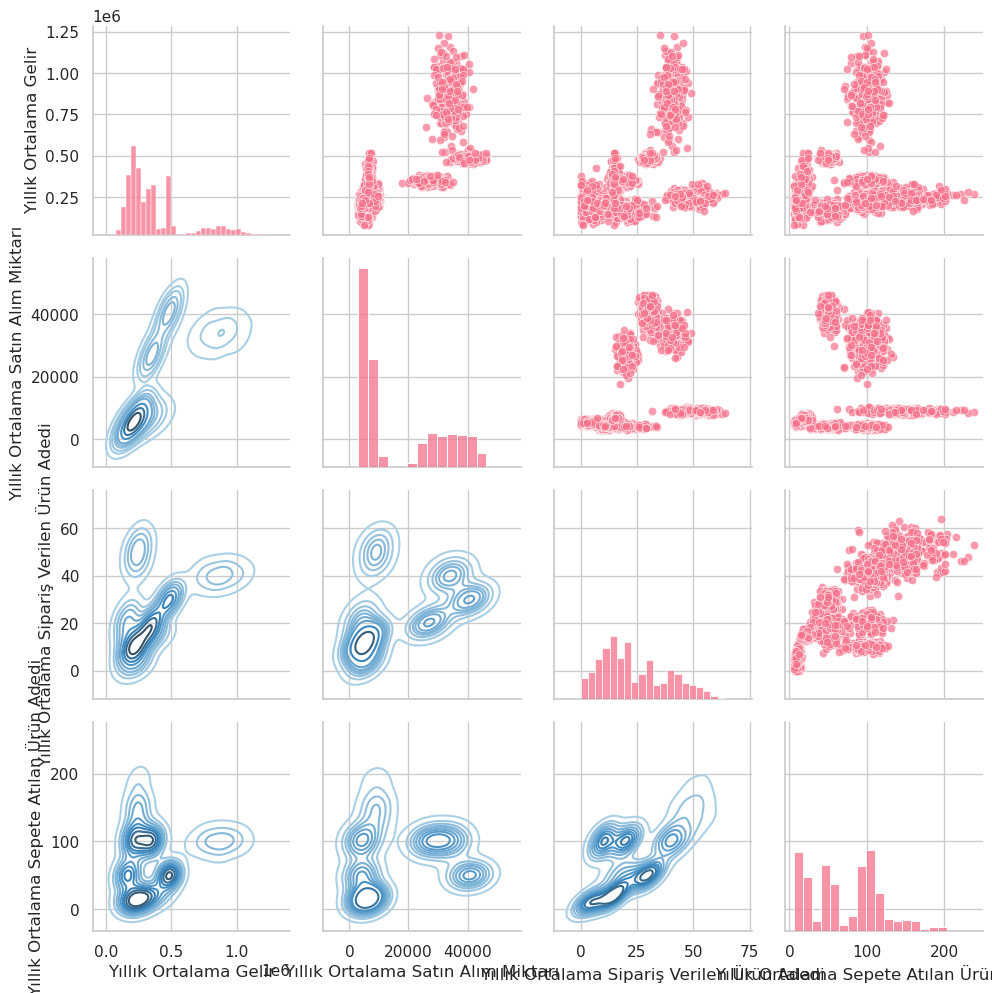

In [33]:
scatter_matrix(test_data)

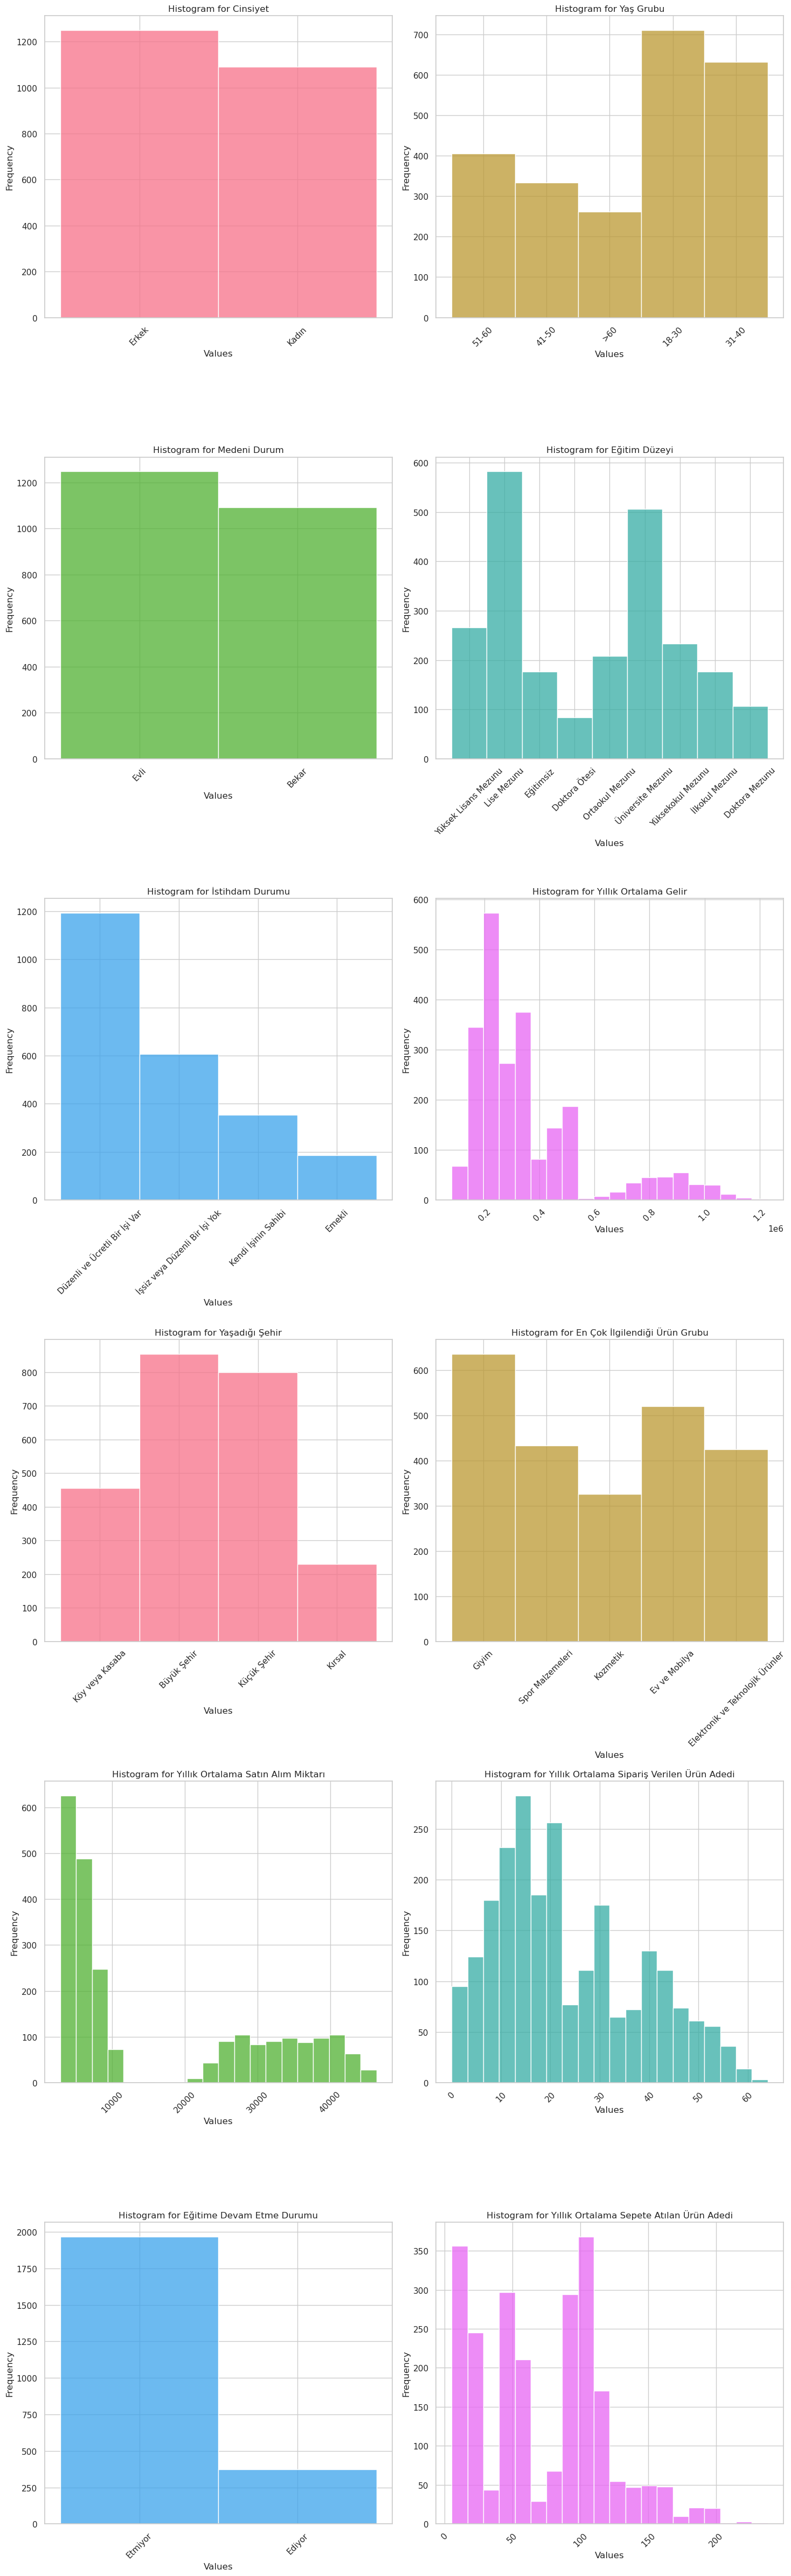

In [34]:
histogram_subplots(test_data, cols_per_row=2)

In [35]:
def outlier_thresholds(dataframe, col, low_quantile=0.25, up_quantile=0.75):
    
    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)
    
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    
    return  low_limit, up_limit

In [36]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(f"{col}, outlier detection is {check_outlier(test_data, col)}")

Yıllık Ortalama Gelir, outlier detection is True
Yıllık Ortalama Satın Alım Miktarı, outlier detection is False
Yıllık Ortalama Sipariş Verilen Ürün Adedi, outlier detection is False
Yıllık Ortalama Sepete Atılan Ürün Adedi, outlier detection is True


In [37]:
class DataProcessorOutlier:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.outlier_clipper:
            print("Applying outlier clipping...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    low_limit, up_limit = outlier_thresholds(dataframe, col)
                    dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
                    dataframe.loc[(dataframe[col] > up_limit), col] = up_limit
            print("Outlier clipping applied.")

        if self.cfg.outlier_remover:
            print("Applying outlier removal...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.25)
                    q3_val = dataframe[col].quantile(0.75)
                    dataframe = dataframe.loc[(dataframe[col] >= q1_val) & (dataframe[col] <= q3_val)]
            print("Outlier removal applied.")
            
        if self.cfg.outlier_replacer:
            print("Applying outlier replacement...")
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.25)
                    q3_val = dataframe[col].quantile(0.75)
                    median_val = dataframe[col].median()
                    dataframe[col] = dataframe[col].where((dataframe[col] >= q1_val) & (dataframe[col] <= q3_val), median_val)
            print("Outlier replacement applied.")

        return dataframe.head()

data_processor = DataProcessorOutlier(CFG())
data_processor.process_data(test_data)

Applying outlier clipping...
Outlier clipping applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,Erkek,51-60,Evli,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,365331.930346,Köy veya Kasaba,Giyim,5566.587664,15.442635,Etmiyor,19.646460
1,Erkek,41-50,Bekar,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,414899.236174,Büyük Şehir,Spor Malzemeleri,6756.766203,14.957246,Etmiyor,19.675863
2,Kadın,>60,Evli,Eğitimsiz,İşsiz veya Düzenli Bir İşi Yok,152825.872271,Küçük Şehir,Giyim,4493.915682,10.907930,Etmiyor,46.904518
3,Kadın,51-60,Evli,Doktora Ötesi,Düzenli ve Ücretli Bir İşi Var,489052.908472,Köy veya Kasaba,Kozmetik,42670.646595,32.333021,Etmiyor,48.083609
4,Erkek,18-30,Evli,Yüksek Lisans Mezunu,Kendi İşinin Sahibi,323635.711534,Küçük Şehir,Giyim,5959.266948,4.519968,Etmiyor,12.752491


In [38]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()>2 and col!= 'index']
            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")

        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()==2 and col!= 'index']
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    unique_values = sorted(dataframe[col].unique())
                    ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                    dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
test_data = data_processor_encode.encode_data(test_data)
test_data.head()

Label encoding applied.
Ordinal encoding applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,3,1,5,0,365331.930346,1,2,5566.587664,15.442635,1,19.646460
1,0,2,0,3,3,414899.236174,0,4,6756.766203,14.957246,1,19.675863
2,1,4,1,2,3,152825.872271,2,2,4493.915682,10.907930,1,46.904518
3,1,3,1,1,0,489052.908472,1,3,42670.646595,32.333021,1,48.083609
4,0,0,1,5,2,323635.711534,2,2,5959.266948,4.519968,1,12.752491


In [39]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        num_cols = ['Yıllık Ortalama Gelir', 'Yıllık Ortalama Satın Alım Miktarı', 
                    'Yıllık Ortalama Sipariş Verilen Ürün Adedi', 
                    'Yıllık Ortalama Sepete Atılan Ürün Adedi']

        if self.cfg.min_max_scaler:
            print("Applying Min-Max scaling...")
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            print("Applying Standard scaling...")
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            print("Applying Robust scaling...")
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe

data_processor_scale = DataProcessorScaled(CFG())
test_data = data_processor_scale.scaled_data(test_data)
test_data.head()

Applying Min-Max scaling...
Min-Max scaling applied.


,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,3,1,5,0,0.370284,1,2,0.061961,0.241225,1,0.065689
1,0,2,0,3,3,0.434757,0,4,0.089316,0.233643,1,0.065824
2,1,4,1,2,3,0.093872,2,2,0.037308,0.170390,1,0.190356
3,1,3,1,1,0,0.531210,1,3,0.914734,0.505066,1,0.195749
4,0,0,1,5,2,0.316048,2,2,0.070986,0.070605,1,0.034159


In [40]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
predictions = model.predict(test_data)

submission = pd.DataFrame({
    "Öbek İsmi": predictions
})

submission["Öbek İsmi"] = "obek_" + submission["Öbek İsmi"].astype(str)
submission.to_csv("submissionx.csv", index=True, index_label='id')

In [41]:
submit = pd.read_csv("/kaggle/working/submissionx.csv")
submit["Öbek İsmi"].value_counts()

obek_1    312
obek_7    306
obek_6    303
obek_4    296
obek_5    292
obek_3    287
obek_8    277
obek_2    267
Name: Öbek İsmi, dtype: int64

In [42]:
test_result = pd.read_csv("/kaggle/working/submissionx.csv")
test_result.rename(columns={'id': 'index'}, inplace=True)
test_data = pd.read_csv("/kaggle/input/datathon2023/test_x.csv")
data = pd.merge(test_result, test_data, on='index', how='left')
data.drop('index', axis=1, inplace=True)
data

,Öbek İsmi,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,obek_3,Erkek,51-60,Evli,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,365331.930346,Köy veya Kasaba,Giyim,5566.587664,15.442635,Etmiyor,19.646460
1,obek_3,Erkek,41-50,Bekar,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,414899.236174,Büyük Şehir,Spor Malzemeleri,6756.766203,14.957246,Etmiyor,19.675863
2,obek_2,Kadın,>60,Evli,Eğitimsiz,İşsiz veya Düzenli Bir İşi Yok,152825.872271,Küçük Şehir,Giyim,4493.915682,10.907930,Etmiyor,46.904518
3,obek_6,Kadın,51-60,Evli,Doktora Ötesi,Düzenli ve Ücretli Bir İşi Var,489052.908472,Köy veya Kasaba,Kozmetik,42670.646595,32.333021,Etmiyor,48.083609
4,obek_1,Erkek,18-30,Evli,Yüksek Lisans Mezunu,Kendi İşinin Sahibi,323635.711534,Küçük Şehir,Giyim,5959.266948,4.519968,Etmiyor,12.752491
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,obek_8,Kadın,18-30,Bekar,Yüksekokul Mezunu,Kendi İşinin Sahibi,259190.078834,Küçük Şehir,Ev ve Mobilya,9559.156534,41.883661,Ediyor,117.627785
2336,obek_2,Kadın,31-40,Evli,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,194580.563177,Kırsal,Ev ve Mobilya,4070.232154,20.082996,Etmiyor,45.659622
2337,obek_7,Erkek,>60,Evli,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,357730.521969,Büyük Şehir,Ev ve Mobilya,22589.204381,18.922305,Etmiyor,100.691379
2338,obek_5,Erkek,18-30,Evli,Doktora Ötesi,Düzenli ve Ücretli Bir İşi Var,213179.637202,Küçük Şehir,Spor Malzemeleri,4205.390562,10.758108,Etmiyor,97.778913


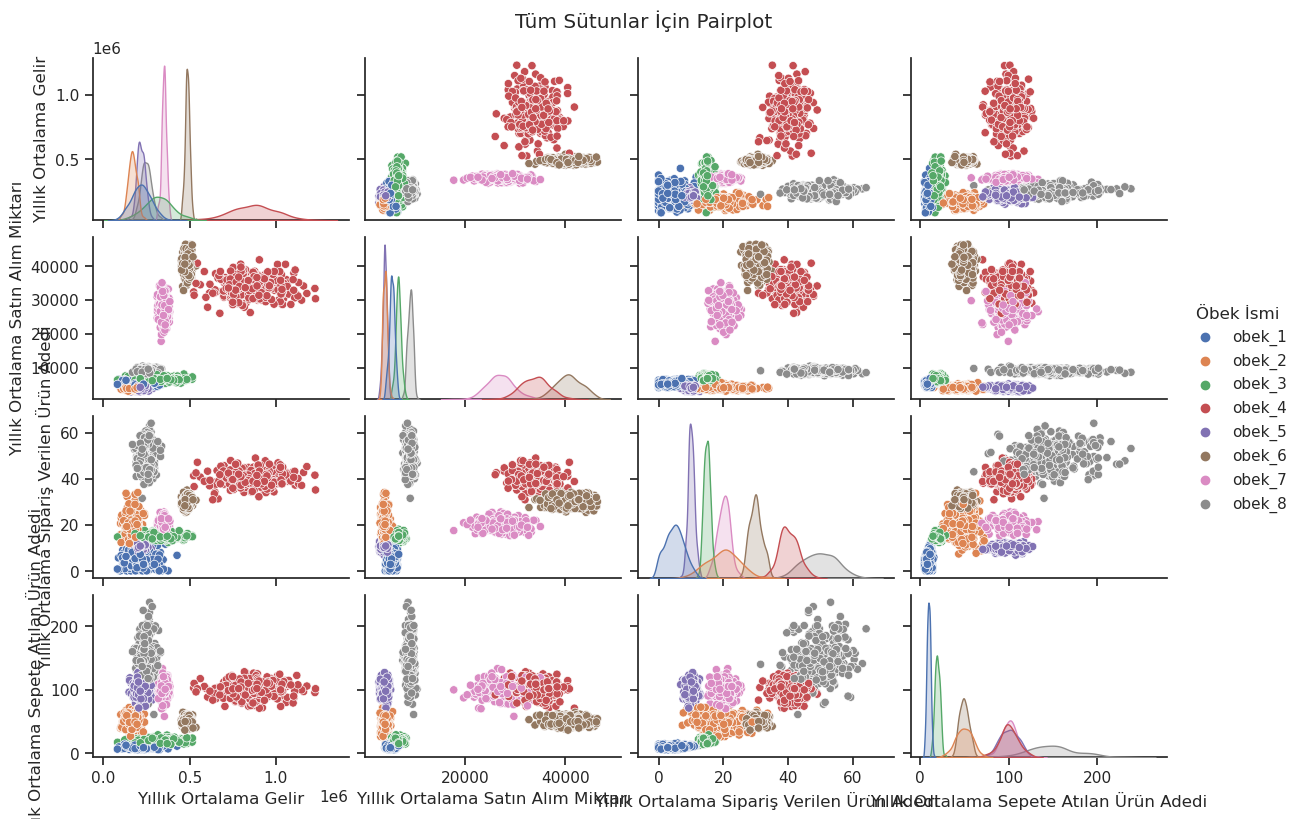

In [43]:
def visualize_relationships(dataframe, target_column):
    dataframe[target_column] = dataframe[target_column].astype('category')
    
    sns.set(style="ticks")
    plot = sns.pairplot(dataframe, hue=target_column, height=2, aspect=1.5)
    plt.suptitle("Tüm Sütunlar İçin Pairplot", y=1.02)
    plt.show()
    
visualize_relationships(data, 'Öbek İsmi')

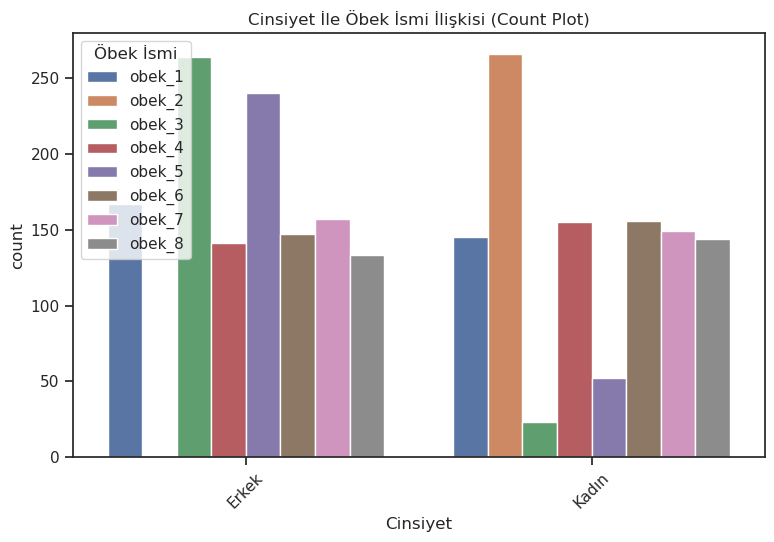

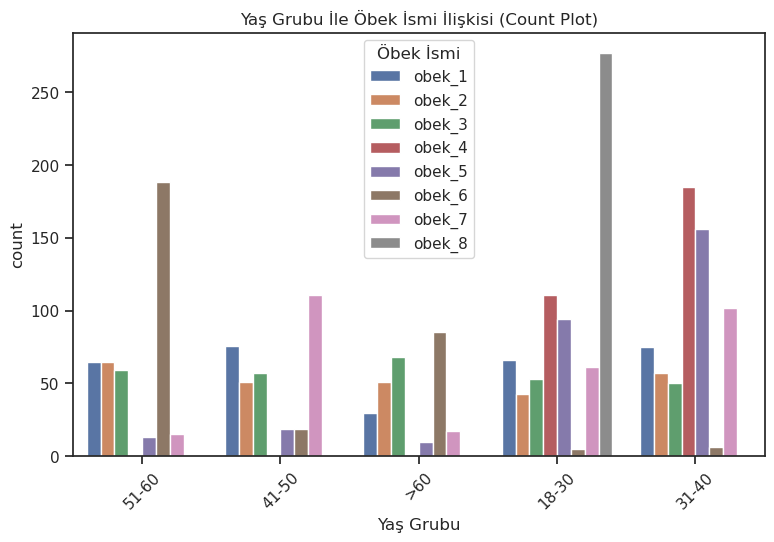

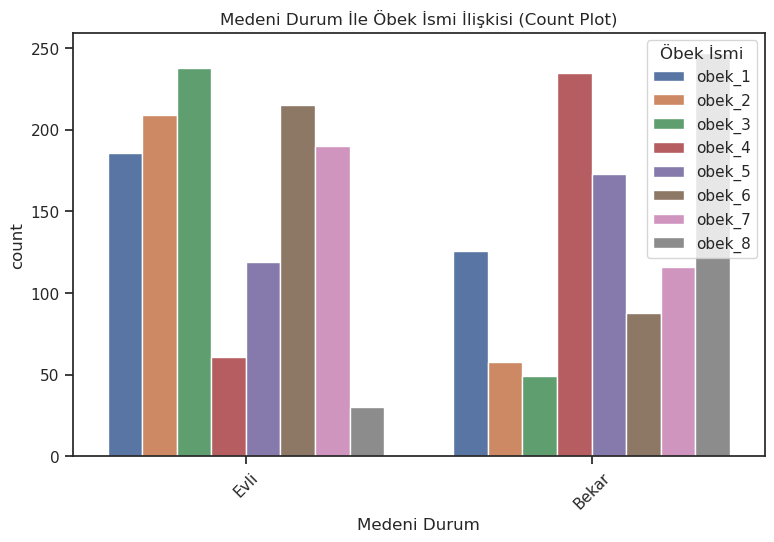

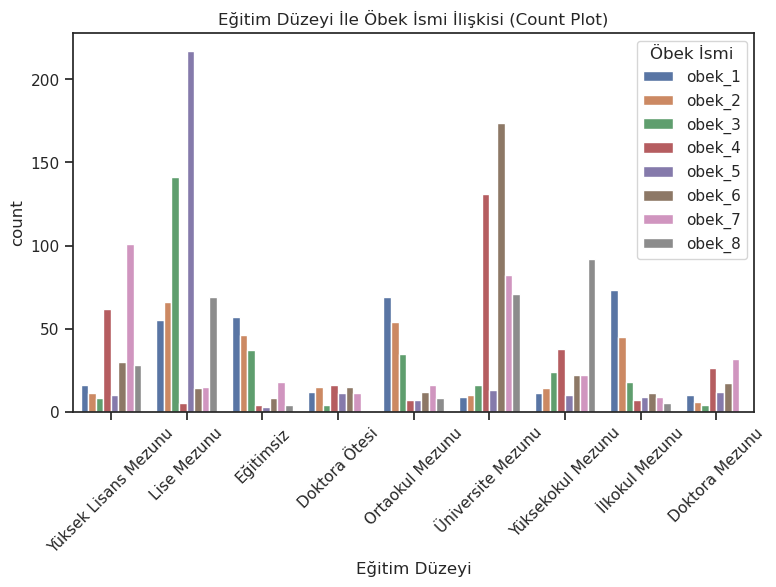

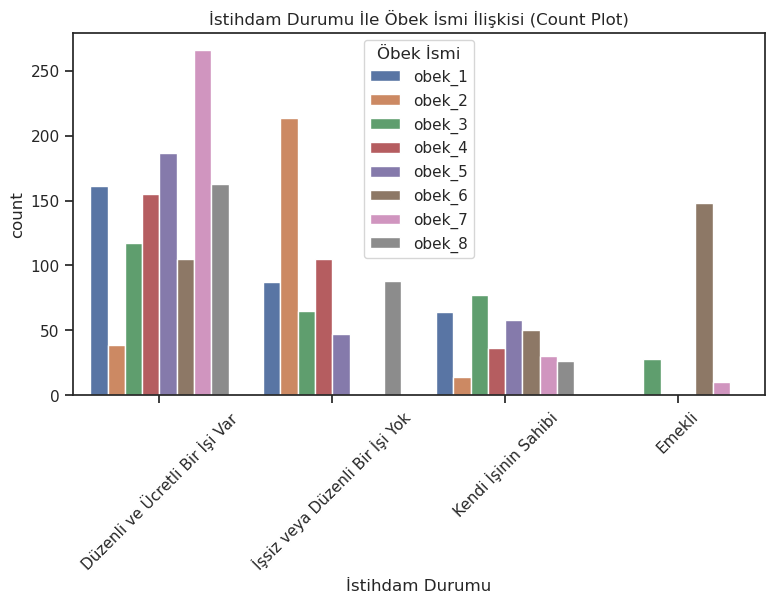

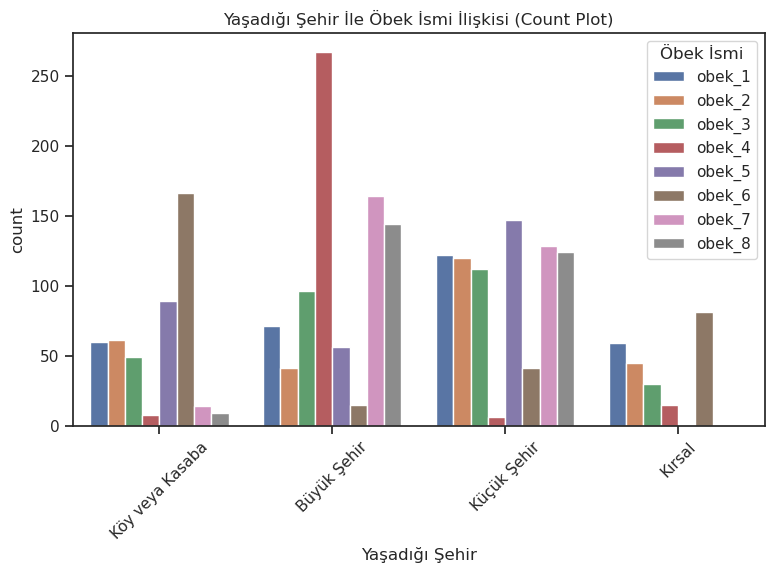

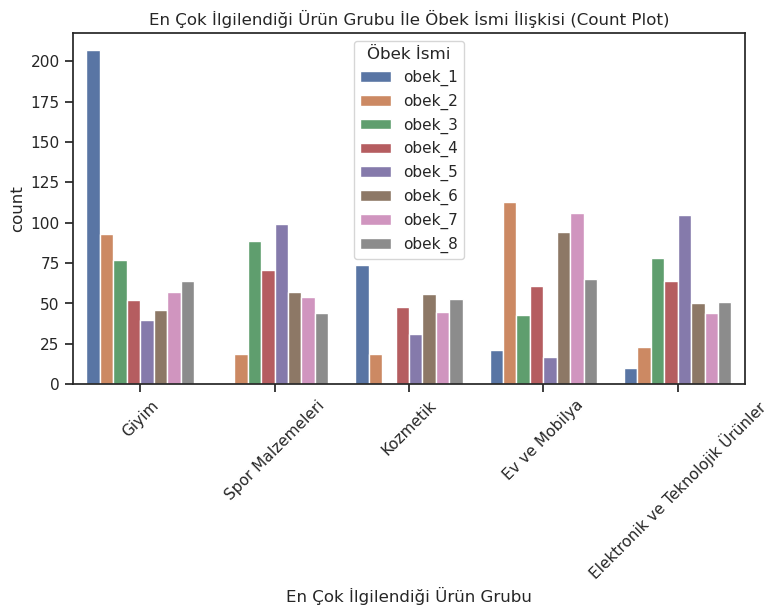

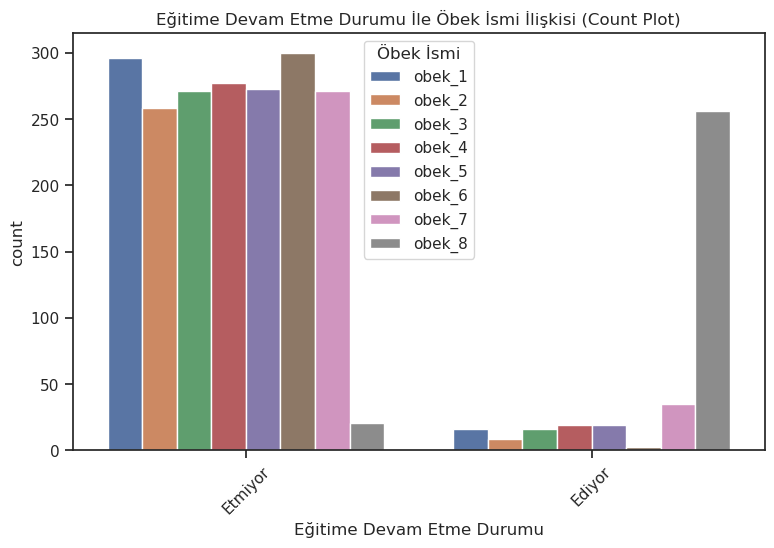

In [44]:
def visualize_categorical_relationships(dataframe, target_column):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    
    for col in cat_cols:
        if col != target_column:
            plt.figure(figsize=(15, 10))
            
            plt.subplot(2, 2, 1)
            sns.countplot(data=dataframe, x=col, hue=target_column)
            plt.title(f"{col} İle {target_column} İlişkisi (Count Plot)")
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()

visualize_categorical_relationships(data, 'Öbek İsmi')